In [4]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
from keras.applications.densenet import DenseNet121, preprocess_input

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import xml.etree.ElementTree as ET

from skimage.io import imread
from skimage.transform import resize
from PIL import Image

## Проверка данных

In [6]:
dataset_folder_path = "D:/datasets/stanford-dogs-dataset"
img_folders_path = dataset_folder_path + "/images/Images"
cropped_path = dataset_folder_path + "/cropped"
annots_path = dataset_folder_path + "/annotations/Annotation"

In [7]:
breed_dirs_list = os.listdir(img_folders_path)

In [15]:
num_classes = len(breed_dirs_list)
print("{} пород".format(num_classes))

120 пород


In [7]:
num_total_images = 0

for breed_dir in breed_dirs_list:
    num_total_images += len(os.listdir(img_folders_path + "/{}".format(breed_dir)))

print("{} изображений всего".format(num_total_images))

20580 изображений всего


In [6]:
dir_idx_map = {}
idx_dir_map = {}

for i, v in enumerate(breed_dirs_list):
    dir_idx_map.update({v : i})
    idx_dir_map.update({i : v})

In [1]:
def print_imgs(dir_name, num_to_show):
    plt.figure(figsize=(16,16))
    
    dir_with_imgs = (img_folders_path + "/{}").format(dir_name)
    imgs = os.listdir(dir_with_imgs)[:num_to_show]
    
    rows_num = num_to_show/4+1
    cols_num = 4
    for i in range(num_to_show):
        img = mpimg.imread(dir_with_imgs + "/" + imgs[i])
        
        position = i+1
        plt.subplot(rows_num, cols_num, position)
        plt.imshow(img)
        plt.axis("off")

n02087046-toy_terrier


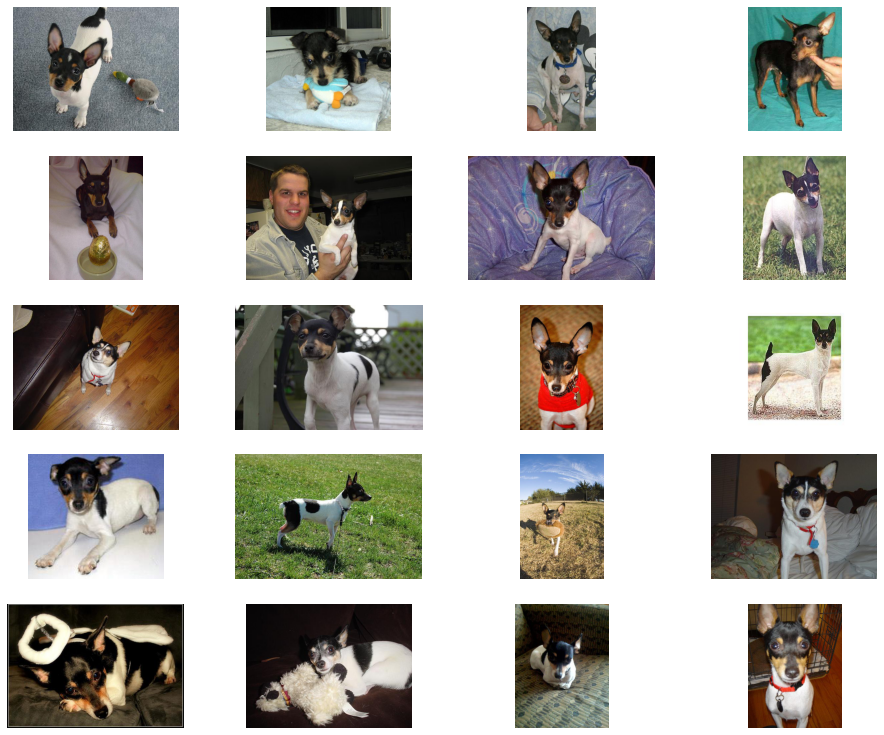

In [10]:
idx=7
print(breed_dirs_list[idx])
print_imgs(breed_dirs_list[idx], 20)

## Предобработка данных

Обрезаем изображение, оставляем только прямоугольник с собачкой.

In [10]:
os.mkdir(cropped_path)

for breed_dir in breed_dirs_list:
    os.mkdir(cropped_path + "/" + breed_dir)

cropped_dirs_list = os.listdir(cropped_path)
print("создано {} папок для хранения обрезанных изображений собак по породам".format(len(cropped_dirs_list)))

создано 120 папок для хранения обрезанных изображений собак по породам


In [11]:
%%time

for breed_name in cropped_dirs_list:
    for file in os.listdir(annots_path + "/{}".format(breed_name)):
        img = Image.open(img_folders_path + "/{}/{}.jpg".format(breed_name, file))
        
        tree = ET.parse(annots_path + "/{}/{}".format(breed_name, file))
        xmin = int(tree.getroot().findall("object")[0].find("bndbox").find("xmin").text)
        xmax = int(tree.getroot().findall("object")[0].find("bndbox").find("xmax").text)
        ymin = int(tree.getroot().findall("object")[0].find("bndbox").find("ymin").text)
        ymax = int(tree.getroot().findall("object")[0].find("bndbox").find("ymax").text)
        
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert("RGB")
        img = img.resize((224, 224))
        img.save(cropped_path + "/" + breed_name + "/" + file + ".jpg")

Wall time: 8min 36s


## Подготовка X и y

In [7]:
def paths_labels_targets():
    paths = list()
    labels = list()
    targets = list()
    
    for breed_name in breed_dirs_list:
        curr_breed_path = cropped_path + "/{}".format(breed_name)
        
        for img_name in os.listdir(curr_breed_path):
            paths.append(curr_breed_path + "/" + img_name)
            labels.append(breed_name)
            targets.append(dir_idx_map[breed_name])
    
    return paths, labels, targets

In [8]:
paths, labels, targets = paths_labels_targets()

In [11]:
assert len(paths) == len(labels)
assert len(paths) == len(targets)

In [12]:
targets = to_categorical(targets, num_classes=num_classes)
targets.shape

(20580, 120)

## Image Generator

In [9]:
class ImageGenerator(Sequence):
 
    def __init__(self, paths, targets, batch_size, shape):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
          
    def __getitem__(self, batch_idx):
        start_path_idx = batch_idx * self.batch_size
        end_path_idx = (batch_idx + 1) * self.batch_size
        batch_paths = self.paths[start_path_idx : end_path_idx]
        
        X = np.zeros((len(batch_paths), 
                      self.shape[0], self.shape[1], self.shape[2]), 
                     dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = imread(path)
            img = preprocess_input(img)
            X[i] = img
        
        y = np.zeros((self.batch_size, num_classes, 1))
        y = self.targets[start_path_idx : end_path_idx]
        
        return X, y

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
                   
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

## Данные для обучения и для валидации

In [10]:
train_paths, valid_paths, train_targets, valid_targets = train_test_split(paths,
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=42)

In [11]:
train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3))
valid_gen = ImageGenerator(valid_paths, valid_targets, batch_size=32, shape=(224,224,3))

## Предобученная модель DenseNet121 на наборе ImageNet

In [13]:
img_input = Input((224, 224, 3))

densenet_model = DenseNet121(input_tensor=img_input,
                       weights="imagenet",
                       include_top=False)

In [16]:
densenet_model.output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'relu')>

In [16]:
# Output -> Pooling -> Dense -> Dropout -> Dense -> Dropout - > Dense

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
classes_output = Dense(num_classes, activation="softmax")(x)

model = Model(img_input, classes_output)

In [24]:
for layer in model.layers[:-6]:
    layer.trainable = False

## Модель в формате PNG

```
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)
```

## Проверка видеокарты

https://www.tensorflow.org/install/gpu

In [11]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Обучение

In [25]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [26]:
%%time

history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=valid_gen, 
                              validation_steps=len(valid_gen),
                              epochs=20)

Epoch 1/20
547/547 [==============================] - 779s 1s/step - loss: 3.2730 - acc: 0.2576 - val_loss: 0.7192 - val_acc: 0.7619
Epoch 2/20
547/547 [==============================] - 138s 252ms/step - loss: 1.1302 - acc: 0.6559 - val_loss: 0.6087 - val_acc: 0.8037
Epoch 3/20
547/547 [==============================] - 135s 247ms/step - loss: 0.9435 - acc: 0.7094 - val_loss: 0.5689 - val_acc: 0.8115
Epoch 4/20
547/547 [==============================] - 137s 251ms/step - loss: 0.8924 - acc: 0.7210 - val_loss: 0.5735 - val_acc: 0.8160
Epoch 5/20
547/547 [==============================] - 138s 253ms/step - loss: 0.8325 - acc: 0.7403 - val_loss: 0.5503 - val_acc: 0.8205
Epoch 6/20
547/547 [==============================] - 140s 255ms/step - loss: 0.7657 - acc: 0.7600 - val_loss: 0.5446 - val_acc: 0.8238
Epoch 7/20
547/547 [==============================] - 139s 253ms/step - loss: 0.7475 - acc: 0.7650 - val_loss: 0.5087 - val_acc: 0.8319
Epoch 8/20
547/547 [==============================]

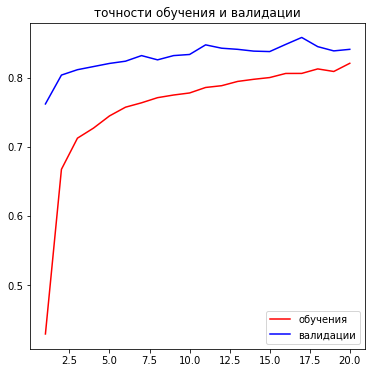

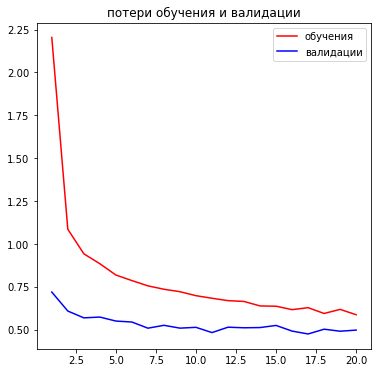

In [29]:
plt.rcParams['figure.figsize'] = (6,6)

epochs = range(1, len(acc) + 1)

plt.title('точности обучения и валидации')
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'red', label='обучения')
plt.plot(epochs, val_acc, 'blue', label='валидации')
plt.legend()

plt.figure()
plt.title('потери обучения и валидации')
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'red', label='обучения')
plt.plot(epochs, val_loss, 'blue', label='валидации')
plt.legend()

plt.show()

# Обучение всех слоёв

In [30]:
for layer in model.layers[:]:
    layer.trainable = True

In [31]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint("dog-breed-classifier-weights.h5", 
                             monitor="val_acc", 
                             verbose=1, 
                             save_best_only=True, 
                             mode="max", 
                             save_weights_only=True)

In [32]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2,
                              patience=1, 
                              verbose=1, 
                              mode="min",
                              min_delta=0.0001, 
                              cooldown=2, 
                              min_lr=1e-7)

In [33]:
early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min",
                           patience=5)

In [34]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=valid_gen, 
                              validation_steps=len(valid_gen)
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 292s 534ms/step - loss: 0.6036 - acc: 0.8136 - val_loss: 0.5057 - val_acc: 0.8419

Epoch 00001: val_acc improved from -inf to 0.84192, saving model to dog-breed-classifier-model.h5
Epoch 2/20
547/547 [==============================] - 139s 254ms/step - loss: 0.5787 - acc: 0.8172 - val_loss: 0.4994 - val_acc: 0.8520

Epoch 00002: val_acc improved from 0.84192 to 0.85196, saving model to dog-breed-classifier-model.h5
Epoch 3/20
547/547 [==============================] - 138s 253ms/step - loss: 0.5758 - acc: 0.8205 - val_loss: 0.4975 - val_acc: 0.8503

Epoch 00003: val_acc did not improve from 0.85196
Epoch 4/20
547/547 [==============================] - 138s 253ms/step - loss: 0.5590 - acc: 0.8267 - val_loss: 0.5413 - val_acc: 0.8312

Epoch 00004: val_acc did not improve from 0.85196

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
547/547 [==============================] - 139s 254ms/step -

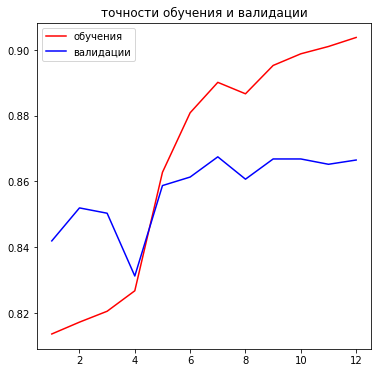

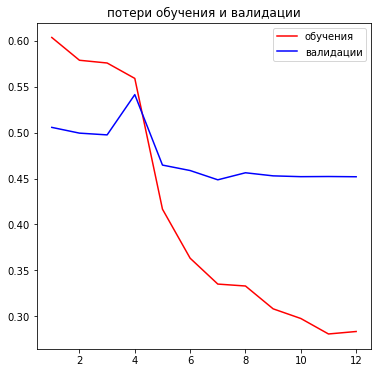

In [35]:
plt.rcParams["figure.figsize"] = (6,6)

epochs = range(1, len(acc) + 1)

plt.title("точности обучения и валидации")
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.plot(epochs, acc, "red", label='обучения')
plt.plot(epochs, val_acc, "blue", label="валидации")
plt.legend()

plt.figure()
plt.title("потери обучения и валидации")
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "red", label="обучения")
plt.plot(epochs, val_loss, "blue", label="валидации")
plt.legend()

plt.show()

In [36]:
print(max(val_acc))

0.8675088882446289


## Предсказание

In [23]:
import json

def read_json(file_name: str):
    with open(file_name) as file_in:
        return json.load(file_in)
    
def predict(file_name):
    img = Image.open(file_name)
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img.save(file_name)

    figure(figsize=(4, 4))
    imshow(img)
    axis("off")

    img = imread(file_name)
    img = preprocess_input(img)
    img = expand_dims(img, axis=0)
    probs = model.predict(img)
    
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", breed_names_map[str(idx)])

def download_and_predict(url, file_name):
    system("curl -s {} -o {}".format(url, file_name))
    predict(file_name)

In [24]:
breed_names_path = "D:/YandexDisk/models/dog-breed-classifier.json"
breed_names_map = read_json(breed_names_path)

99.99% 	 Pomeranian
0.01% 	 keeshond
0.00% 	 toy_poodle
0.00% 	 Chihuahua
0.00% 	 Pekinese


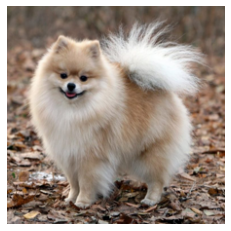

In [27]:
download_and_predict("https://i.imgur.com/QzxTOG1.jpg",
                     "pomeranian.jpg")

99.69% 	 Doberman
0.26% 	 miniature_pinscher
0.05% 	 tan_coonhound
0.00% 	 toy_terrier
0.00% 	 Mexican_hairless


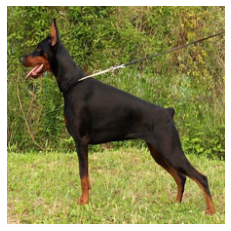

In [31]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/7/7a/European_Dobermann.jpg",
                     "doberman.jpg")

99.99% 	 pug
0.00% 	 bull_mastiff
0.00% 	 Brabancon_griffon
0.00% 	 Tibetan_mastiff
0.00% 	 Norwegian_elkhound


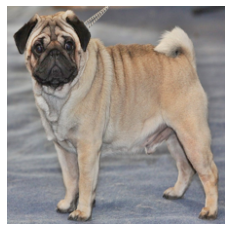

In [32]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg",
                     "pug.jpg")

100.00% 	 chow
0.00% 	 Tibetan_mastiff
0.00% 	 Samoyed
0.00% 	 Pomeranian
0.00% 	 Newfoundland


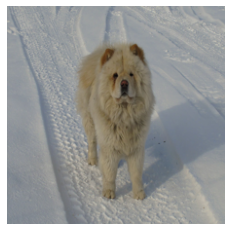

In [33]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/c/c7/ChowChow1.jpg",
                     "chow.jpg")